# Libraries

In [1]:
# Libraries for the VAE model
import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

# Libraries for the median model
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull


Bad key text.latex.preview in file C:\Users\AMIRHOSEIN\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\AMIRHOSEIN\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\AMIRHOSEIN\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality paramet

# The VAE model

## Preparing the dataset

In [12]:
# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the FashionMNIST datasets
path = '~/datasets'
train_dataset = FashionMNIST(path, transform=transform, download=True)
test_dataset  = FashionMNIST(path, transform=transform, download=True)
AAA=train_dataset

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


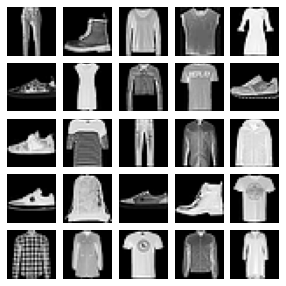

In [4]:
# get 25 sample training images for visualization
dataiter = iter(train_loader)
image = dataiter.next()

num_samples = 25
sample_images = [image[0][i,0] for i in range(num_samples)] 

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

# Defining the VAE class 

In this section We define the VAE model. The encoder encodes a 28 in 28 image to a 4 dimensional space and then using reparameterazitation we decrease the features to 2 (mean and variance). After that, using the decoder we transform the latent point to a 28 in 28 image again. 

In [5]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = 0.04*torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, log_var
        
    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) 
        x_hat = self.decode(z)  
        return x_hat, mean, log_var
    
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


def train(model, optimizer, epochs, device, x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

In [6]:
# We use Adam for the optimizer
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

In [7]:
train(model, optimizer, epochs=50, device=device)

	Epoch 1 	Average Loss:  279.1709015351106
	Epoch 2 	Average Loss:  263.6873655636999
	Epoch 3 	Average Loss:  260.92012892581386
	Epoch 4 	Average Loss:  259.3107443395242
	Epoch 5 	Average Loss:  258.13516094532554
	Epoch 6 	Average Loss:  257.2952115831073
	Epoch 7 	Average Loss:  256.62578089132927
	Epoch 8 	Average Loss:  256.1516671666319
	Epoch 9 	Average Loss:  255.64369183013355
	Epoch 10 	Average Loss:  255.05846616104967
	Epoch 11 	Average Loss:  254.83176544240402
	Epoch 12 	Average Loss:  254.51536199655675
	Epoch 13 	Average Loss:  254.10517786806136
	Epoch 14 	Average Loss:  253.82065294370827
	Epoch 15 	Average Loss:  253.62190874765233
	Epoch 16 	Average Loss:  253.55231058926336
	Epoch 17 	Average Loss:  253.11332879017112
	Epoch 18 	Average Loss:  253.02283379199707
	Epoch 19 	Average Loss:  252.78871889346829
	Epoch 20 	Average Loss:  252.60446541762312
	Epoch 21 	Average Loss:  252.41571033102045
	Epoch 22 	Average Loss:  252.3185006260434
	Epoch 23 	Average Loss: 

14953578.861328125

## Visualizing the output

Here we generate some images using the decoder

In [8]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

0


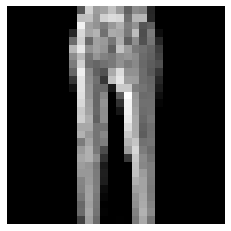

1


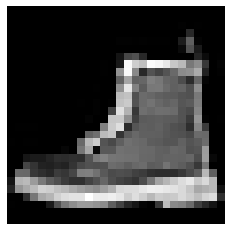

2


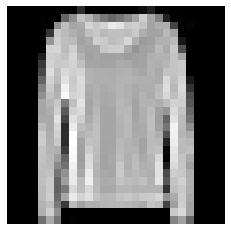

3


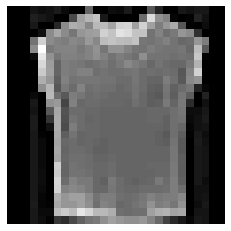

4


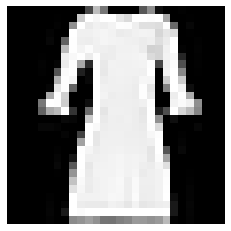

5


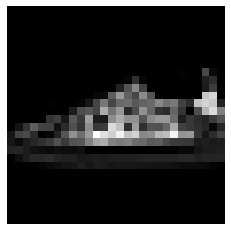

6


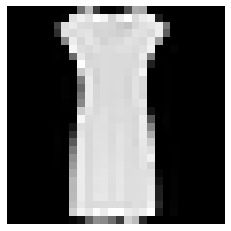

7


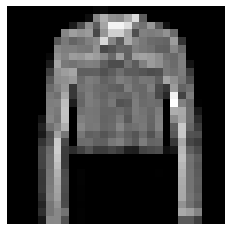

8


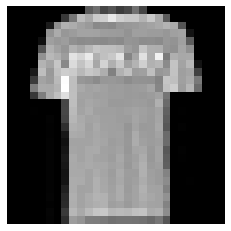

9


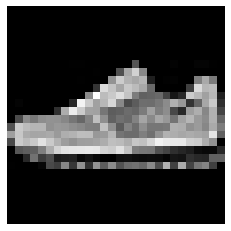

10


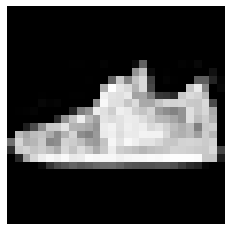

11


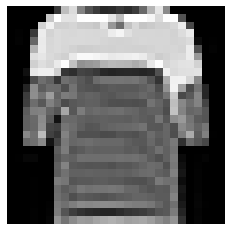

12


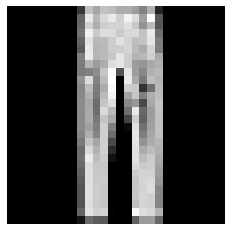

13


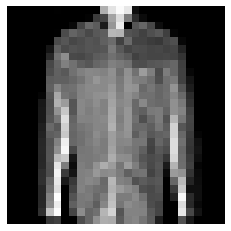

14


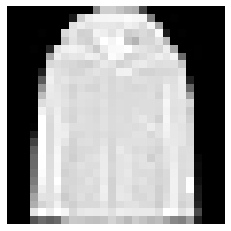

15


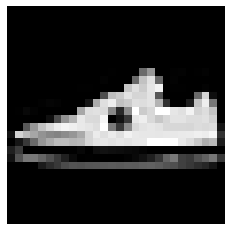

16


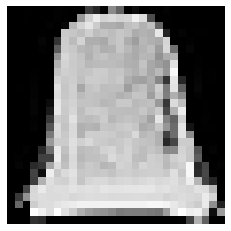

17


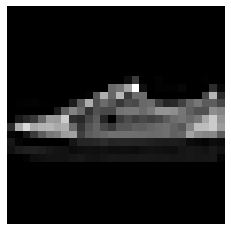

18


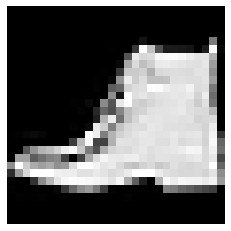

19


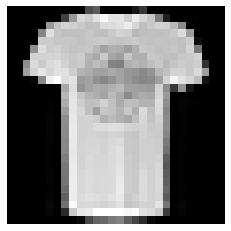

20


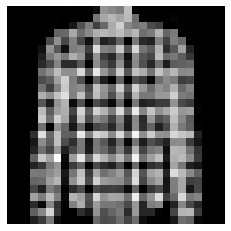

21


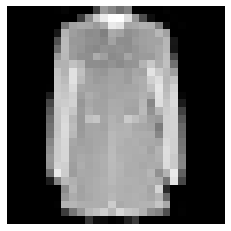

22


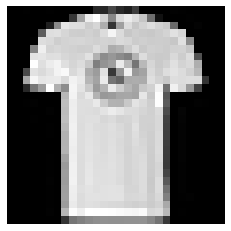

23


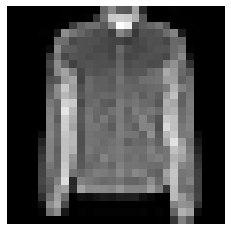

24


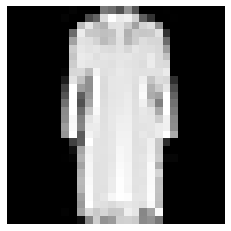

25


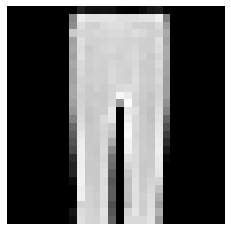

26


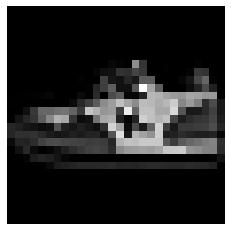

27


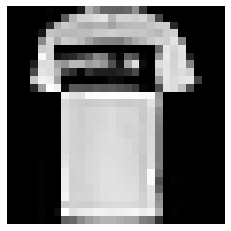

28


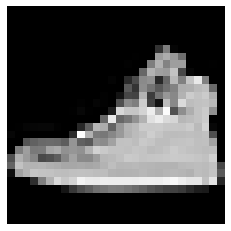

29


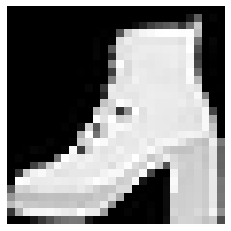

30


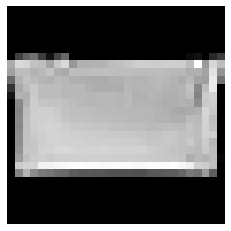

31


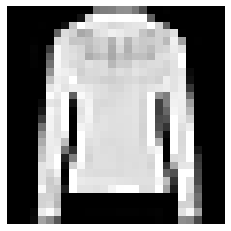

32


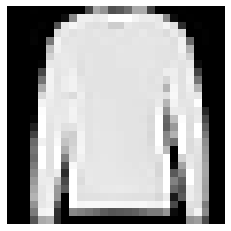

33


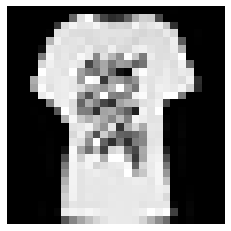

34


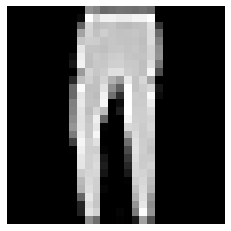

35


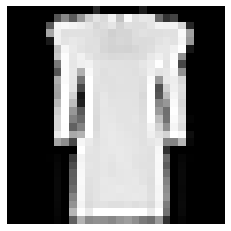

36


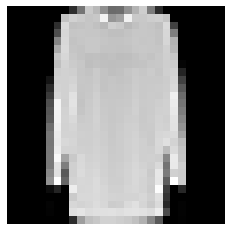

37


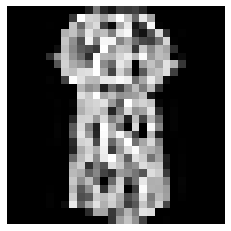

38


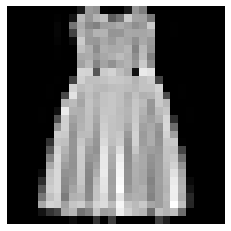

39


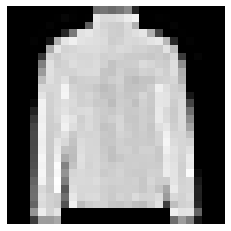

40


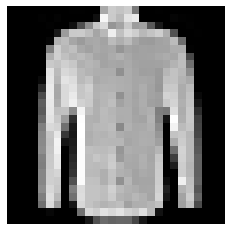

41


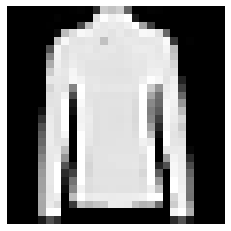

42


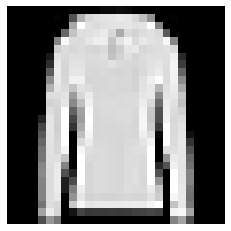

43


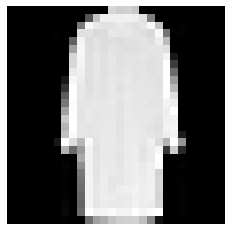

44


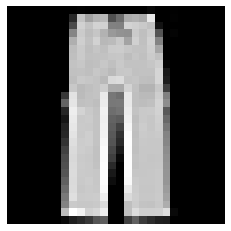

45


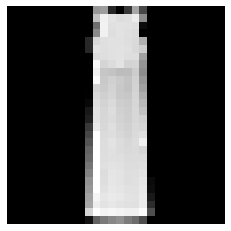

46


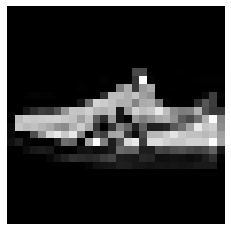

47


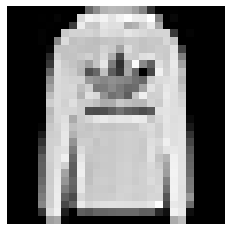

48


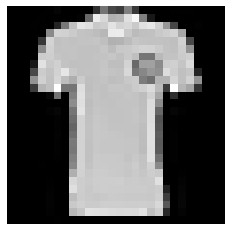

49


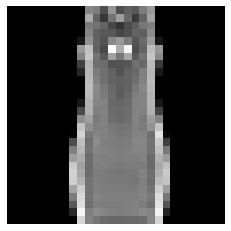

50


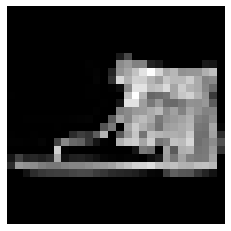

51


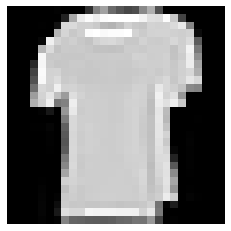

52


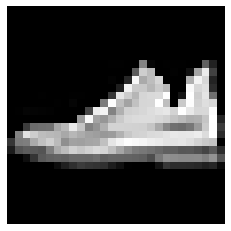

53


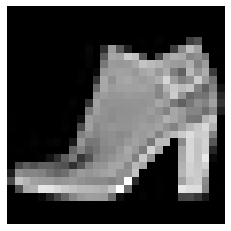

54


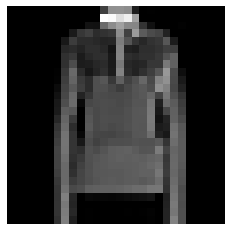

55


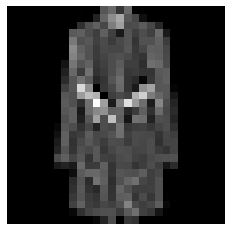

56


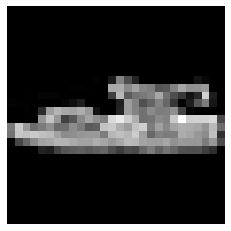

57


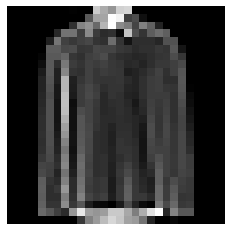

58


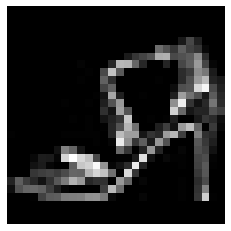

59


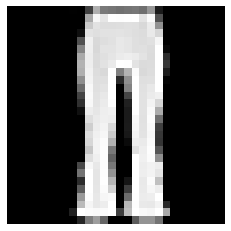

60


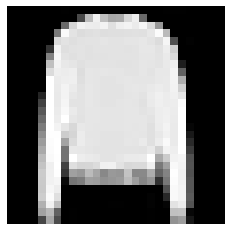

61


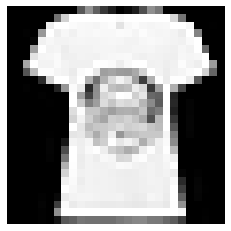

62


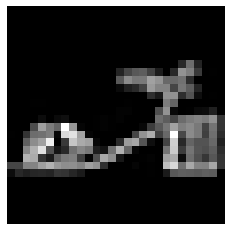

63


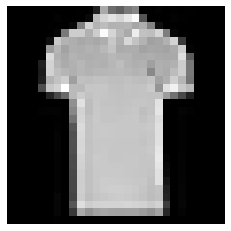

64


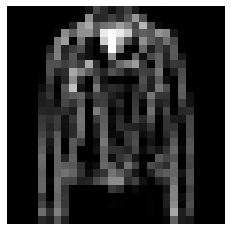

65


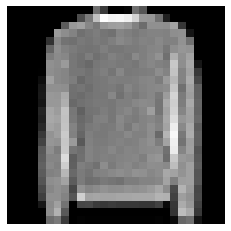

66


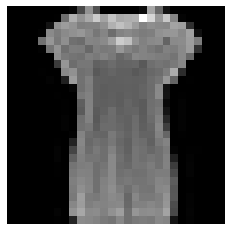

67


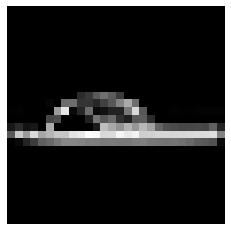

68


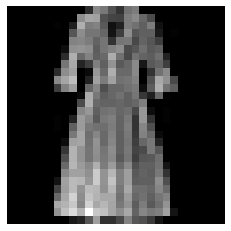

69


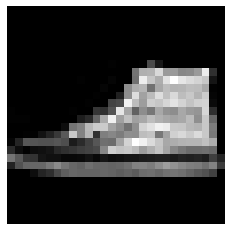

70


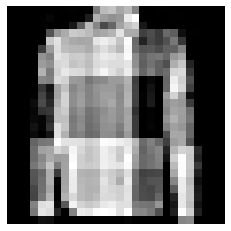

71


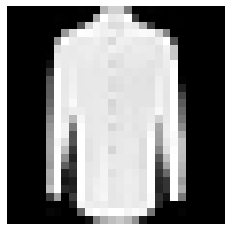

72


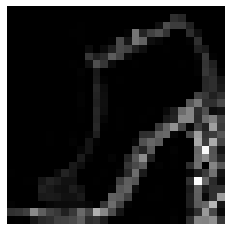

73


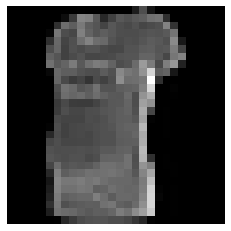

74


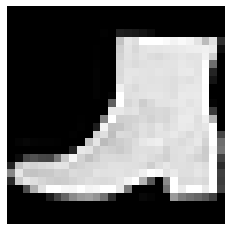

75


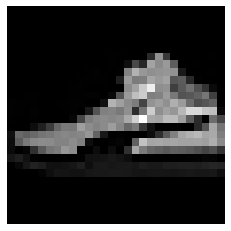

76


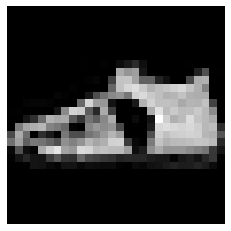

77


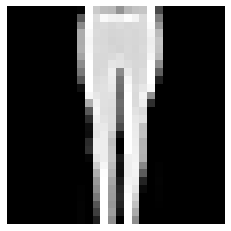

78


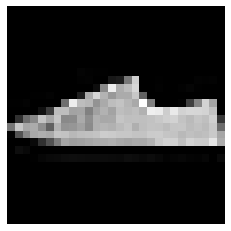

79


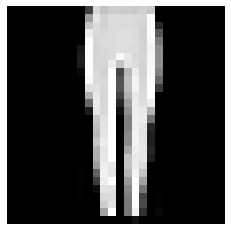

80


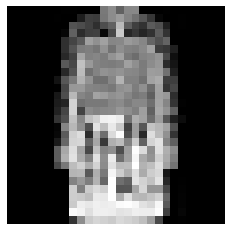

81


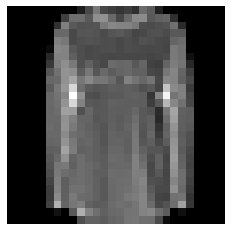

82


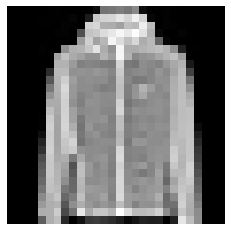

83


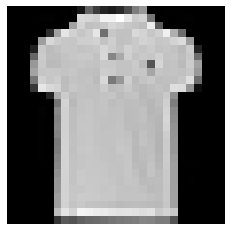

84


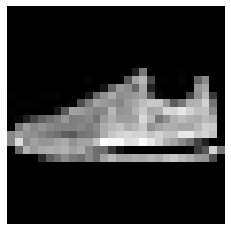

85


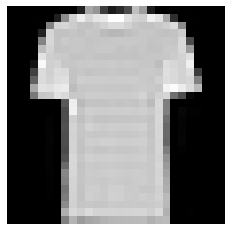

86


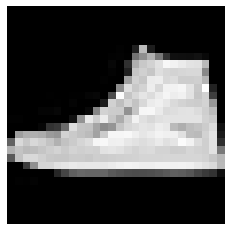

87


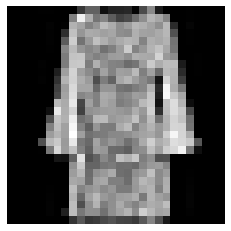

88


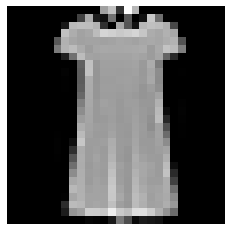

89


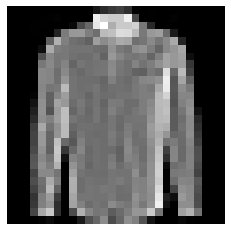

90


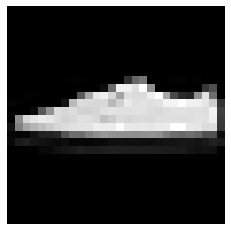

91


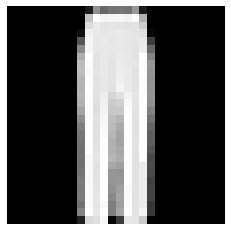

92


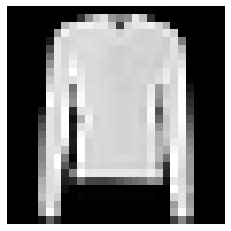

93


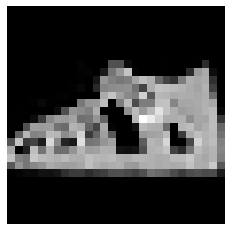

94


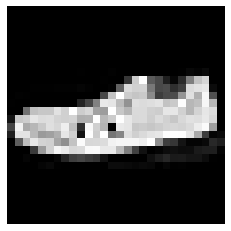

95


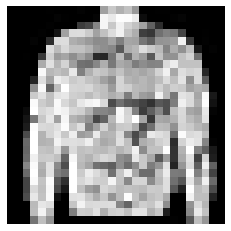

96


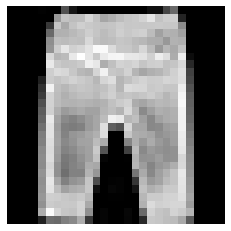

97


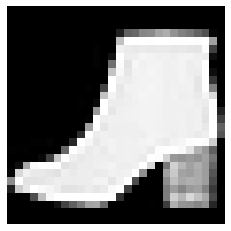

98


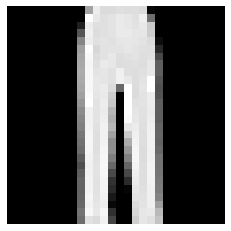

99


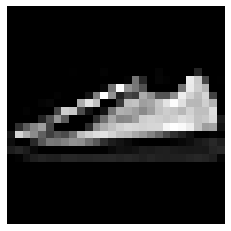

In [14]:
for ind in range(100):
    print(ind)
    plt.imshow(image[0][ind].reshape(28,28), cmap="gray")
    plt.axis('off')
    plt.show()

In [15]:
shirts=[2,13,14,20,31,32,36,39,40,41,42,47,54,57,60]
boots=[97,74,53,29,18,1]

Here is one of the samples in the data

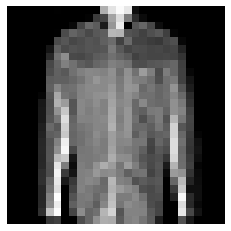

In [19]:
ind=13
plt.imshow(image[0][ind].reshape(28,28), cmap="gray")
plt.axis('off')
plt.show()

Now we reconstruct the same sample using the VAE model

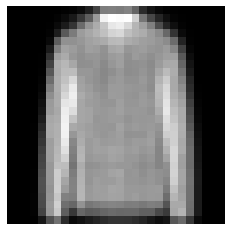

In [20]:
z1=model.encode(image[0][ind].reshape(1, 784))
z1=model.reparameterization(z1[0],z1[1])
generate_digit(z1[0][0],z1[0][1])

The third figure is a random shoe generated by the VAE given a random latent point

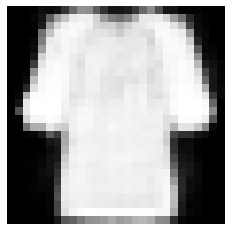

In [21]:
generate_digit(-2,-1)

Now we plot the outputs given different latent points.

In [22]:
def plot_latent_space(model, scale=5.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

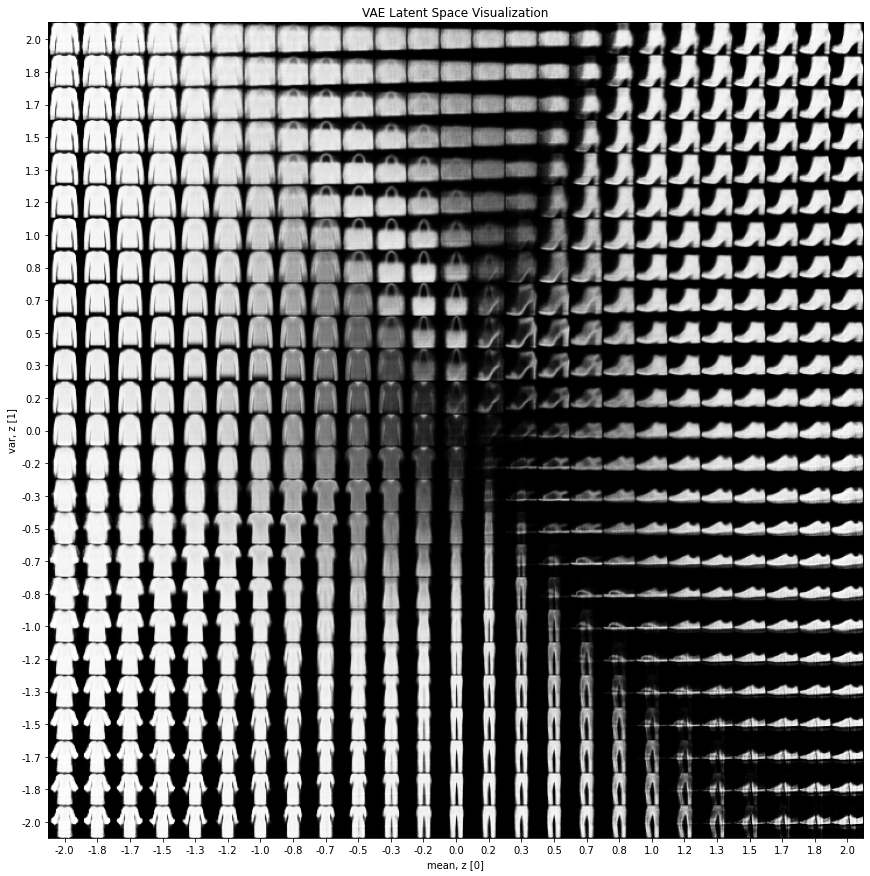

In [23]:
plot_latent_space(model, scale=2)

# The HDD 

## Defining the HDD functions

In [24]:
def hyperplane_from_d_points(points): #finds the hyperplane passing through d points in d dimensions. 
    points=np.array(points)
    k = np.ones(points.shape[0])
    a=np.dot(np.linalg.inv(points), k)
    unit_normal_vector= a / np.linalg.norm(a)
    distance_to_origin: float = -1 / np.linalg.norm(a)
#     distance_to_origin: float = 1 / np.linalg.norm(a)

    return [unit_normal_vector,distance_to_origin]


def find_all_hyperplanes(P): #given a set of n poitns, computes all the hyperplanes passing through each d points in d dimensions
    P=np.array(P)
    dim=P.shape[1]
    C=np.array(list(combinations(P, dim)))
    hyperplanes=[]
    for i in C:
        hyperplanes.append(hyperplane_from_d_points(i))
    return np.array(hyperplanes)

# def find_intersection_point(h1,h2):
#     A=[[h1[0]],[h2[0]]]
#     B=[[h1[1]],[h2[2]]]
#     return np.linalg.solve(A, B)

def find_all_intersections(H): #finds all the intersection points (answers) of the hyperplanes (equations) in H
    dim=H[0][0].shape[0]
    C=np.array(list(combinations(H, dim)))
    intersections=[]
    for i in C:
        A=[]
        B=[]
        for j in i:
            A.append(j[0])
            B.append(j[1])
        A=np.array(A)
        B=np.array(B)
        intersections.append(np.linalg.solve(A, -B))
    return np.array(intersections)

def distance_from_point_to_hyperplane(p,h): #computes the distance of point p to the hyperplane h. (both in d dimension)
    p=np.array(p)
    h=np.array(h)
    return abs(np.dot(h[0],p)+h[1])/np.linalg.norm(h[0])

# def add_noise_features(P,seed=431,v=0.00001):
#     n=P.shape[0]
#     d=P.shape[1]
#     if d<n-2:
#         np.random.seed(seed)
#         extra=v*np.random.normal(size=(n,n-2-d))
#         return np.concatenate((P, extra), axis=1)
    

## Testing the HDD median

 In this section we generate 12 points in R^2 and find their HDD median (using a bruth force algorithm which is different from the method in my thesis). 
P is the set of points.
H is the set of n choose d hyperplanes passing through each d points of P.
F is the set of all the intersection points between these hyperplanes.


In [37]:
np.random.seed(431)
P= np.random.rand(12,2)
# P=np.concatenate((P,np.array([[3,3]])))
H=find_all_hyperplanes(P)
F=find_all_intersections(H)
depth_measures=[]
m=float('inf')
for i in F:
    depth=0
    for j in H:
        depth=depth+distance_from_point_to_hyperplane(i,j)
    depth_measures.append([i,depth])
    if depth<m:
        m=depth
        median=i
print("median location:",median,"\nHDD measure:",m)

C:\Users\AMIRHOSEIN\anaconda3\lib\site-packages\ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


median location: [0.3254015  0.50342991] 
HDD measure: 10.629370413415698


Now we plot the HDD median and compare it with the famous L2 median (that is the average and is used to compute the MSE)

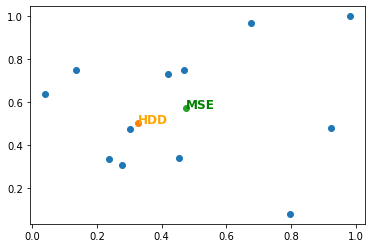

In [38]:
plt.scatter(P[:,0],P[:,1])

plt.scatter(median[0],median[1])
plt.text(median[0],median[1], "HDD", horizontalalignment='left', size='large', color='orange', weight='semibold')

sumX=np.sum(P[:,0])
sumY=np.sum(P[:,1])
l=P[:,0].shape[0]
plt.scatter(sumX/l,sumY/l)
plt.text(sumX/l,sumY/l, "L2", horizontalalignment='left', size='large', color='green', weight='semibold')

plt.show()

Now we compare the two depth measures' robustness giving an example. This example shows that the HDD median works better dealing with outliers. The green point is the average that is far from the center and the orange point is the HDD medain.

In [39]:
np.random.seed(403)
P= np.random.rand(12,2)
P=np.concatenate((P,np.array([[4,4]])))
H=find_all_hyperplanes(P)
F=find_all_intersections(H)
depth_measures=[]
m=float('inf')
for i in F:
    depth=0
    for j in H:
        depth=depth+distance_from_point_to_hyperplane(i,j)
    depth_measures.append([i,depth])
    if depth<m:
        m=depth
        median=i
print("median location:",median,"\nHDD measure:",m)

C:\Users\AMIRHOSEIN\anaconda3\lib\site-packages\ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


median location: [0.303083   0.54755112] 
HDD measure: 9.177168711456948


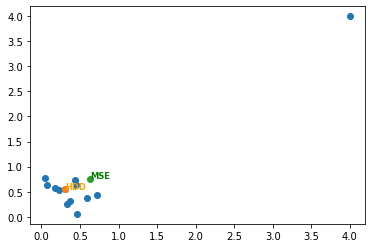

In [40]:
plt.scatter(P[:,0],P[:,1])

plt.scatter(median[0],median[1])
plt.text(median[0],median[1], "HDD", horizontalalignment='left', size='small', color='orange', weight='semibold')

sumX=np.sum(P[:,0])
sumY=np.sum(P[:,1])
l=P[:,0].shape[0]
plt.scatter(sumX/l,sumY/l)
plt.text(sumX/l,sumY/l, "L2", horizontalalignment='left', size='small', color='green', weight='semibold')

plt.show()

# Testing HDD using the decoder

## HDD vs L2 

### EXP1

In this section we reconstruct some samples using the VAE and then we reconstruct the HDD median and the L2 median of those inputs to compare them

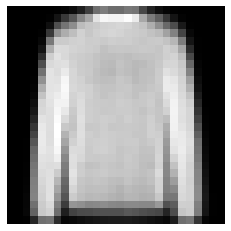

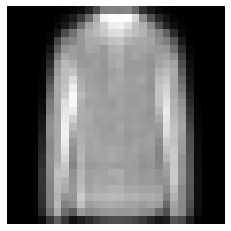

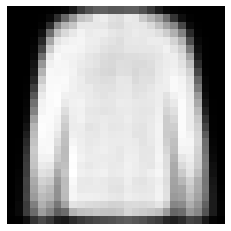

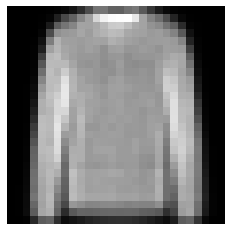

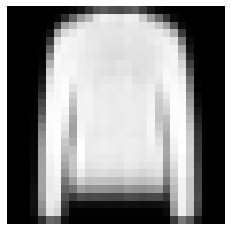

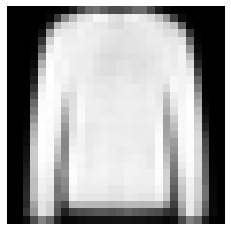

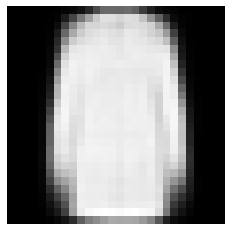

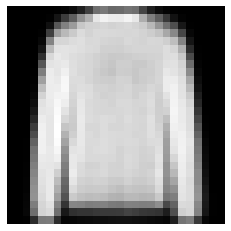

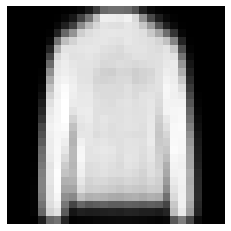

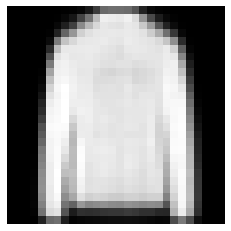

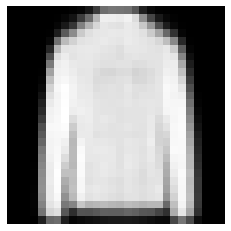

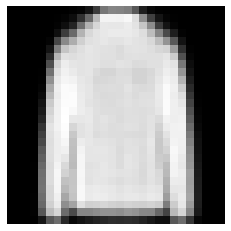

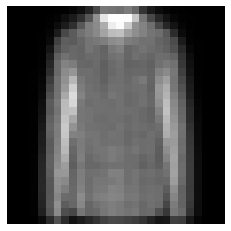

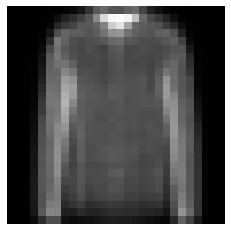

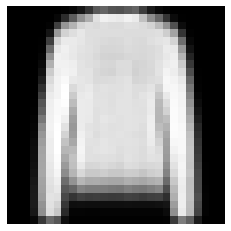

C:\Users\AMIRHOSEIN\anaconda3\lib\site-packages\ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


median location: [-1.30094     0.42509374] 
HDD measure: 19.10458806549468


In [26]:
P=[]
shirts=[2,13,14,20,31,32,36,39,40,41,42,47,54,57,60]
boots=[97,74,53,29,18,1]

for i in shirts:
    z1=model.encode(image[0][i].reshape(1, 784))
    z1=model.reparameterization(z1[0],z1[1])
    P.append([z1[0][0].item(),z1[0][1].item()])
    generate_digit(z1[0][0],z1[0][1])
P=np.array(P)

H=find_all_hyperplanes(P)
F=find_all_intersections(H)
depth_measures=[]
m=float('inf')
for i in F:
    depth=0
    for j in H:
        depth=depth+distance_from_point_to_hyperplane(i,j)
    depth_measures.append([i,depth])
    if depth<m:
        m=depth
        median=i
print("median location:",median,"\nHDD measure:",m)

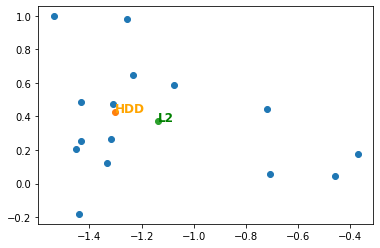

In [28]:
plt.scatter(P[:,0],P[:,1])

plt.scatter(median[0],median[1])
plt.text(median[0],median[1], "HDD", horizontalalignment='left', size='large', color='orange', weight='semibold')

sumX=np.sum(P[:,0])
sumY=np.sum(P[:,1])
l=P[:,0].shape[0]
plt.scatter(sumX/l,sumY/l)
plt.text(sumX/l,sumY/l, "L2", horizontalalignment='left', size='large', color='green', weight='semibold')

plt.show()

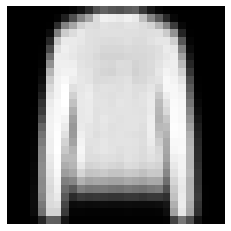

image generated using the HDD median


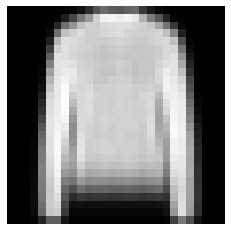

image generated using the L2 median


In [29]:
generate_digit(median[0],median[1])
print("image generated using the HDD median")
generate_digit(sumX/l,sumY/l)
print("image generated using the L2 median")

### EXP2

Now we do the same experiment adding some outliers

Encoding some samples from differnt classes into a 2 dimensional latent space

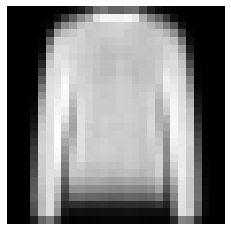

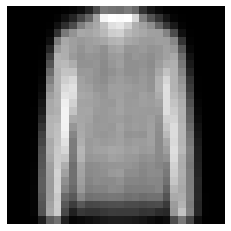

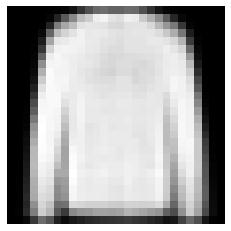

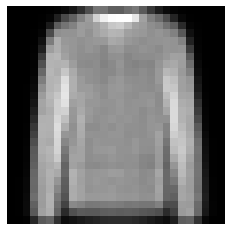

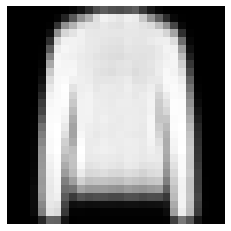

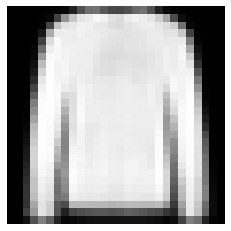

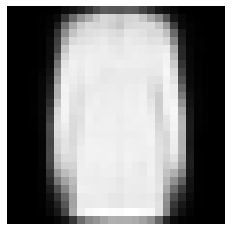

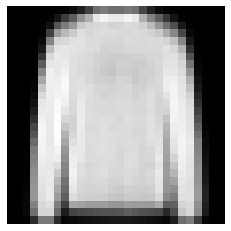

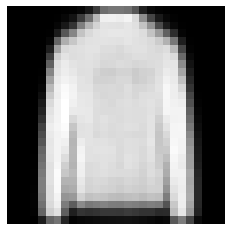

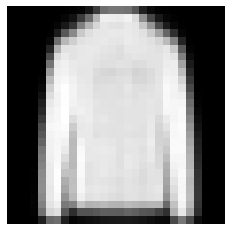

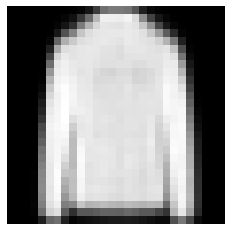

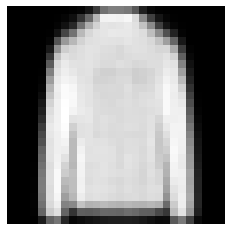

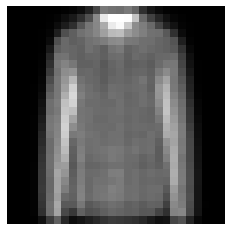

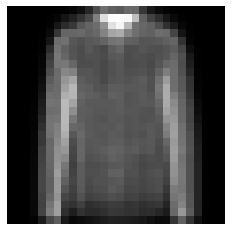

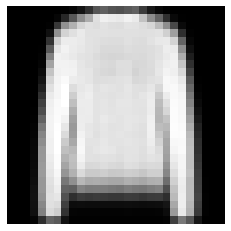

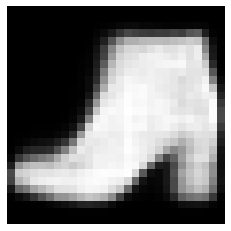

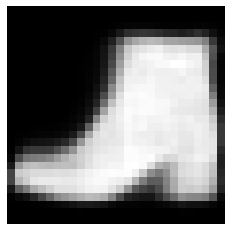

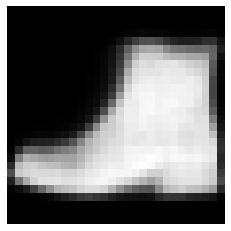

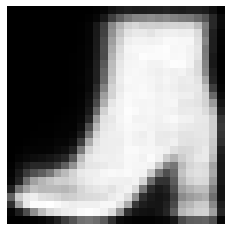

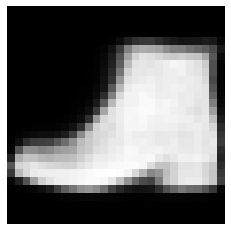

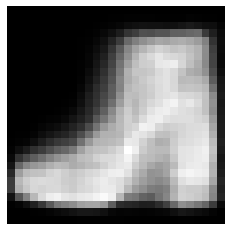

C:\Users\AMIRHOSEIN\anaconda3\lib\site-packages\ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


median location: [-1.07652239  0.31880193] 
HDD measure: 65.50984119872945


In [34]:
P=[]
shirtsANDnoise=[2,13,14,20,31,32,36,39,40,41,42,47,54,57,60,97,74,53,29,18,1]
boots=[97,74,53,29,18,1]
for i in shirtsANDnoise:
    z1=model.encode(image[0][i].reshape(1, 784))
    z1=model.reparameterization(z1[0],z1[1])
    P.append([z1[0][0].item(),z1[0][1].item()])
    generate_digit(z1[0][0],z1[0][1])
P=np.array(P)

H=find_all_hyperplanes(P)
F=find_all_intersections(H)
depth_measures=[]
m=float('inf')
for i in F:
    depth=0
    for j in H:
        depth=depth+distance_from_point_to_hyperplane(i,j)
    depth_measures.append([i,depth])
    if depth<m:
        m=depth
        median=i
print("median location:",median,"\nHDD measure:",m)

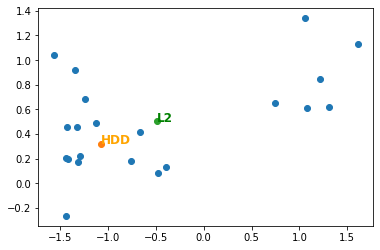

In [35]:
plt.scatter(P[:,0],P[:,1])

plt.scatter(median[0],median[1])
plt.text(median[0],median[1], "HDD", horizontalalignment='left', size='large', color='orange', weight='semibold')

sumX=np.sum(P[:,0])
sumY=np.sum(P[:,1])
l=P[:,0].shape[0]
plt.scatter(sumX/l,sumY/l)
plt.text(sumX/l,sumY/l, "L2", horizontalalignment='left', size='large', color='green', weight='semibold')

plt.show()

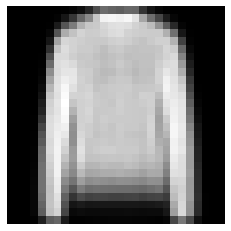

image generated using the HDD median


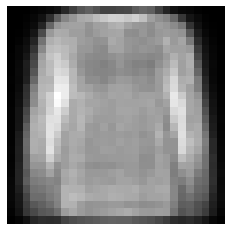

image generated using the L2 median


In [36]:
generate_digit(median[0],median[1])
print("image generated using the HDD median")
generate_digit(sumX/l,sumY/l)
print("image generated using the L2 median")